## The Darcy's equation (continuous inputs)

## (1) Problem Description
We consider the following Darcy flows in a 2D area filled with porous materials. The governing PDE is 
$$
-\nabla( K(x,y) \nabla P(x,y)) = f(x,y), \quad x\in\Omega
$$  
where $K$ is the permeability field, $P$ is the pressure, and $f$ is a source term which can be either a constant or a space-dependent function. 

We consider a problem with a rectangular domain $\Omega=[0,1]^2$ with zero Dirichlet boundary condition. We are interested in learning the mapping from the permeability field $K(x,y)$ to the pressure field $P(x,y)$, i.e.,
$$
\mathcal{G}: K(x,y) \rightarrow P(x,y)
$$

## (2) The Deep Generative Neural Operator (DGNO)
[DGenNO: A Novel Physics-aware Neural Operator for Solving Forward and Inverse PDE Problems based on Deep, Generative Probabilistic Modeling](https://arxiv.org/pdf/2502.06250)

### (2.1) Prepare data

The shape of x_train: torch.Size([1000, 841, 2])
The shape of a_train: torch.Size([1000, 841, 1])
The shape of gridx_train: torch.Size([841, 2])
**********************************
The shape of x_test: torch.Size([200, 841, 2])
The shape of a_test: torch.Size([200, 841, 1])
The shape of u_test: torch.Size([200, 841, 1])
The shape of gridx_test: torch.Size([841, 2])


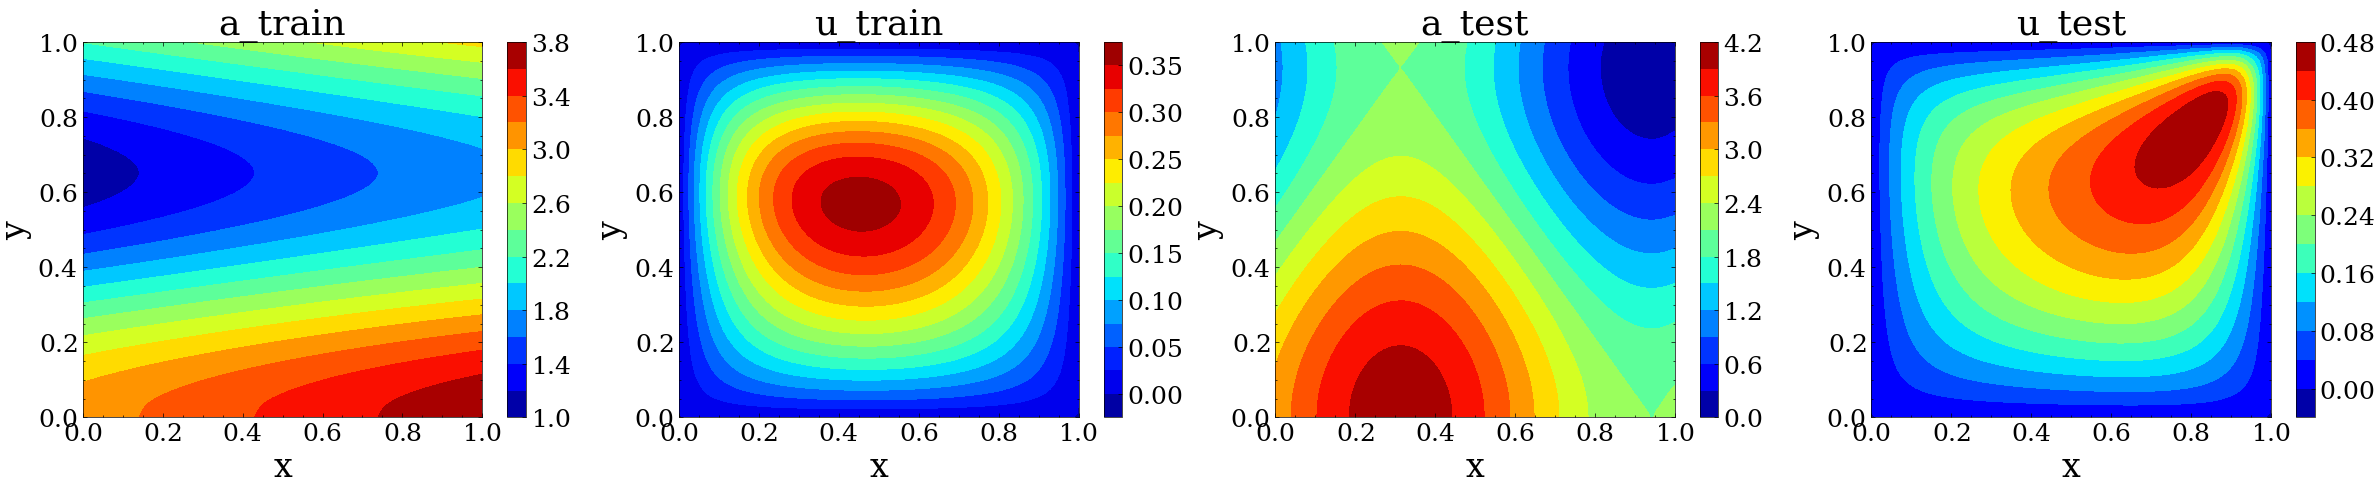

In [1]:
import sys 
sys.path.append("..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 10086
setup_seed(random_seed)
device = 'cuda:1'
dtype = torch.float32

######################################
# Load training data
######################################
from Utils.utils import *
#
def get_data(data, dtype):
    a = np2tensor(np.array(data["coeff"]).T, dtype)
    u = np2tensor(np.array(data["sol"]).T, dtype)
    #
    X, Y = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
    gridx = mesh.reshape(-1, 2)
    #
    ndata = a.shape[0]
    a = a.reshape(ndata, -1, 1)
    x = gridx.repeat((ndata, 1, 1))
    u = u.reshape(ndata, -1, 1)
    
    return a, u, x, gridx
#
data_train = h5py.File('dataset/smh_train.mat', 'r')
data_test = h5py.File('dataset/smh_test_in.mat', 'r')
a_train, u_train, x_train, gridx_train = get_data(data_train, dtype)
a_test, u_test, x_test, gridx_test = get_data(data_test, dtype)
#
print('The shape of x_train:', x_train.shape)
print('The shape of a_train:', a_train.shape)
print('The shape of gridx_train:', gridx_train.shape)
print('**********************************')
print('The shape of x_test:', x_test.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of gridx_test:', gridx_test.shape)
########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list([gridx_train]*3+[gridx_test], [a_train[0], u_train[0], a_test[0], u_test[0]], 
                  ['a_train', 'u_train', 'a_test', 'u_test'], lb =0.)

### (2.2) Define the loss class

In [2]:
import torch.nn as nn
from torch.autograd import grad, Variable
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
#
from Utils.GenPoints import Point2D
genPoint = Point2D(x_lb=[0., 0.], x_ub=[1., 1.], dataType=dtype)
###############################
# The test function
###############################
int_grid, v, dv_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=9, dataType=dtype).get_testFun()
print('int_grid shape:', int_grid.shape, 'v shape:', v.shape)

######################################
## The mollifier (to satisfy the boundary condition)
######################################
class mollifier(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, x):
        u = u * torch.sin(np.pi * x[...,0])*torch.sin(np.pi * x[...,1])
        return u.unsqueeze(-1)
        
##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.fun_a = fun_a
        self.model_enc = solver.model_dict['enc']
        self.model_u = solver.model_dict['u']
        self.model_a = solver.model_dict['a']
        self.mollifier = mollifier()
        #######################
        self.n_grid = int_grid.shape[0]
        self.int_grid = int_grid.to(self.device)
        self.v = v.to(self.device)
        self.dv_dr = dv_dr.to(self.device)

    def Loss_pde(self, a_batch, nc=100):
        ''' 
        Input:
            a_batch: size(n_batch, n_mesh, 1)
        '''
        beta = self.model_enc(a_batch)
        n_batch = a_batch.shape[0]
        ############### Data points ###############
        # xc:size(nc, 1, 2) R:size(nc, 1, 1)
        xc, R = genPoint.weight_centers(n_center=nc, R_max=1e-4, R_min=1e-4)
        xc, R = xc.to(self.device), R.to(self.device)
        # size(nc, n_grid, 2)
        x = self.int_grid * R + xc
        # size(nc*n_grid, 2) -> (n_batch, nc*n_grid, 2)
        x = x.reshape(-1, 2).repeat((n_batch,1,1))
        x = Variable(x, requires_grad=True)
        ############### Test functions #############
        v = self.v.repeat((nc,1,1)).reshape(-1,1)
        dv = (self.dv_dr / R).reshape(-1, 2)
        ################ model prediction ###########
        a_detach = self.fun_a(x.detach(), a_batch)
        u = self.model_u(x, beta)
        u = self.mollifier(u, x)
        # du: size(n_batch, nc*n_grid, 2)
        du = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f = 10. * torch.ones_like(u)
        ################ PDE loss ####################  
        # size(n_batch, nc*n_grid, 2) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        left = torch.sum( a_detach*du*dv, dim=-1).reshape(n_batch, nc, self.n_grid)
        left = torch.mean(left, dim=-1)
        # size(n_batch, nc*n_grid, 1) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        right = (f * v).reshape(n_batch, nc, self.n_grid)
        right = torch.mean(right, dim=-1)
        ################################################
        res = (left-right)**2
        res, indices = torch.sort(res.flatten(), descending=True, dim=0)
        loss_res = torch.sum( res[0:100*10] )

        return self.solver.getLoss(left, right) + loss_res 
        
    def Loss_data(self, x, a, u):
        '''Note: u is not used for training
        '''
        beta = self.model_enc(a)
        a_pred = self.model_a(x, beta)
        ############# The reconstruction loss
        loss_a = self.solver.getLoss(a_pred, a.squeeze(-1))
        
        return loss_a

    def Error(self, x, a, u):
        beta = self.model_enc(a)
        u_pred = self.model_u(x, beta)
        u_pred = self.mollifier(u_pred, x)

        return self.solver.getError(u_pred, u)

######################################
# Steups of the model
######################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
netType = 'MultiONetBatch'
beta_size = 128
hidden_size = 100
fun_a = solver.getModel_a(Exact_a=None, approximator='RBF', 
                          **{'x_mesh':gridx_train, 'kernel':'gaussian', 
                             'eps':25., 'smoothing':0., 'degree':6.})

####################################### The Encoder
from Networks.EncoderNet import EncoderCNNet2d
class Encoder(nn.Module):
    def __init__(self, conv_arch:list, fc_arch:list, 
                 nx_size:int, ny_size:int, dtype=None):
        super(Encoder, self).__init__()
        self.conv = EncoderCNNet2d(conv_arch=conv_arch, fc_arch=fc_arch,
                                   activation_conv='SiLU', activation_fc='SiLU',
                                   nx_size=nx_size, ny_size=ny_size, 
                                   kernel_size=(3,3), stride=2, dtype=dtype)
        
    def forward(self, feat):
        '''
        Input:
            feat: size(?, ny*nx, 1)
        Return:
            output: size(?, out_size)
        '''
        beta = self.conv(feat)
        
        return torch.tanh(beta)

conv_arch = [1, 64, 64, 64]
fc_arch = [64*2*2, 128, 128, beta_size]
model_enc = Encoder(conv_arch, fc_arch, nx_size=29, ny_size=29, 
                    dtype=dtype).to(device)

###################################### The Decoder
trunk_layers, branch_layers = [hidden_size]*6, [hidden_size]*6
#
model_a = solver.getModel(x_in_size=2, beta_in_size=beta_size, 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk='Tanh_Sin', activation_branch='Tanh_Sin',
                           netType=netType, sum_layers=5)
model_u = solver.getModel(x_in_size=2, beta_in_size=beta_size, 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk='Tanh_Sin', activation_branch='Tanh_Sin',
                           netType=netType, sum_layers=5)

# ###############################
total_trainable_params_enc = sum(p.numel() for p in model_enc.parameters() if p.requires_grad)
print(f'{total_trainable_params_enc:,} training parameters.')
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')
#
print(f'{total_trainable_params_enc + total_trainable_params_u*2:,} total parameters')

int_grid shape: torch.Size([45, 2]) v shape: torch.Size([45, 1])
140,416 training parameters.
114,206 training parameters.
368,828 total parameters


### (2.3) train the model

In [3]:
model_dict = {'u':model_u, 'a':model_a, 'enc':model_enc}
solver.train_setup(model_dict, lr=5e-4, optimizer='AdamW', scheduler_type='StepLR', 
                   gamma=0.5, step_size=np.int32(2000/5))
solver.train(LossClass, a_train, u_train, x_train, a_test, u_test, x_test, 
             w_data=0.25, w_pde=1., batch_size=50, epochs=2000, epoch_show=100,
             **{'save_path':f'saved_models/DGNO_latent{beta_size}/'})

  0%|                                                                                        | 0/2000 [00:00<?, ?it/s]/home/yaohua/anaconda3/envs/dnn-python309/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  5%|███▉                                                                          | 100/2000 [02:59<56:23,  1.78s/it]

Epoch:100 Time:179.2082, loss:54.4862, loss_pde:54.1568, loss_data:1.3173
                l2_test:0.0335, lr:0.0005


 10%|███████▊                                                                      | 200/2000 [05:57<53:24,  1.78s/it]

Epoch:200 Time:357.2744, loss:30.7144, loss_pde:30.4815, loss_data:0.9317
                l2_test:0.0208, lr:0.0005


 15%|███████████▋                                                                  | 300/2000 [08:55<50:19,  1.78s/it]

Epoch:300 Time:535.3272, loss:18.7188, loss_pde:18.5571, loss_data:0.6471
                l2_test:0.0169, lr:0.0005


 20%|███████████████▌                                                              | 400/2000 [11:53<47:21,  1.78s/it]

Epoch:400 Time:713.1374, loss:27.5713, loss_pde:27.3189, loss_data:1.0099
                l2_test:0.0379, lr:0.00025


 25%|███████████████████▌                                                          | 500/2000 [14:51<44:27,  1.78s/it]

Epoch:500 Time:891.0456, loss:9.9352, loss_pde:9.8359, loss_data:0.3974
                l2_test:0.0139, lr:0.00025


 30%|███████████████████████▍                                                      | 600/2000 [17:49<41:32,  1.78s/it]

Epoch:600 Time:1069.0442, loss:10.3602, loss_pde:10.2425, loss_data:0.4707
                l2_test:0.0248, lr:0.00025


 35%|███████████████████████████▎                                                  | 700/2000 [20:47<38:34,  1.78s/it]

Epoch:700 Time:1247.0855, loss:9.1135, loss_pde:9.0097, loss_data:0.4153
                l2_test:0.0133, lr:0.00025


 40%|███████████████████████████████▏                                              | 800/2000 [23:45<35:36,  1.78s/it]

Epoch:800 Time:1425.1187, loss:6.9033, loss_pde:6.7895, loss_data:0.4551
                l2_test:0.0131, lr:0.000125


 45%|███████████████████████████████████                                           | 900/2000 [26:43<32:38,  1.78s/it]

Epoch:900 Time:1603.2959, loss:8.2575, loss_pde:8.1817, loss_data:0.3033
                l2_test:0.0104, lr:0.000125


 50%|██████████████████████████████████████▌                                      | 1000/2000 [29:41<29:44,  1.78s/it]

Epoch:1000 Time:1781.3255, loss:6.5683, loss_pde:6.4855, loss_data:0.3310
                l2_test:0.0118, lr:0.000125


 55%|██████████████████████████████████████████▎                                  | 1100/2000 [32:40<26:42,  1.78s/it]

Epoch:1100 Time:1960.1079, loss:8.1088, loss_pde:8.0293, loss_data:0.3178
                l2_test:0.0079, lr:0.000125


 60%|██████████████████████████████████████████████▏                              | 1200/2000 [35:38<23:44,  1.78s/it]

Epoch:1200 Time:2138.8333, loss:7.2129, loss_pde:7.1393, loss_data:0.2945
                l2_test:0.0133, lr:6.25e-05


 65%|██████████████████████████████████████████████████                           | 1300/2000 [38:37<20:44,  1.78s/it]

Epoch:1300 Time:2317.8478, loss:2.7769, loss_pde:2.7350, loss_data:0.1675
                l2_test:0.0069, lr:6.25e-05


 70%|█████████████████████████████████████████████████████▉                       | 1400/2000 [41:36<18:06,  1.81s/it]

Epoch:1400 Time:2496.9671, loss:2.7188, loss_pde:2.6800, loss_data:0.1552
                l2_test:0.0048, lr:6.25e-05


 75%|█████████████████████████████████████████████████████████▊                   | 1500/2000 [44:37<14:52,  1.79s/it]

Epoch:1500 Time:2677.0400, loss:2.4062, loss_pde:2.3709, loss_data:0.1411
                l2_test:0.0055, lr:6.25e-05


 80%|█████████████████████████████████████████████████████████████▌               | 1600/2000 [47:36<11:51,  1.78s/it]

Epoch:1600 Time:2856.3356, loss:3.0558, loss_pde:3.0187, loss_data:0.1482
                l2_test:0.0077, lr:3.125e-05


 85%|█████████████████████████████████████████████████████████████████▍           | 1700/2000 [50:34<08:53,  1.78s/it]

Epoch:1700 Time:3034.1872, loss:1.8111, loss_pde:1.7927, loss_data:0.0735
                l2_test:0.0038, lr:3.125e-05


 90%|█████████████████████████████████████████████████████████████████████▎       | 1800/2000 [53:32<05:56,  1.78s/it]

Epoch:1800 Time:3212.2433, loss:1.6026, loss_pde:1.5825, loss_data:0.0803
                l2_test:0.0064, lr:3.125e-05


 95%|█████████████████████████████████████████████████████████████████████████▏   | 1900/2000 [56:30<02:58,  1.78s/it]

Epoch:1900 Time:3390.5865, loss:1.8115, loss_pde:1.7899, loss_data:0.0865
                l2_test:0.0048, lr:3.125e-05


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [59:28<00:00,  1.78s/it]

Epoch:2000 Time:3568.9653, loss:1.7149, loss_pde:1.6913, loss_data:0.0945
                l2_test:0.0037, lr:1.5625e-05
The total training time is 3568.9752


### (2.4) make prediction with trained model

The test l2 error (u avg): tensor(0.0033)
The test l2 error (a avg): tensor(0.0011)


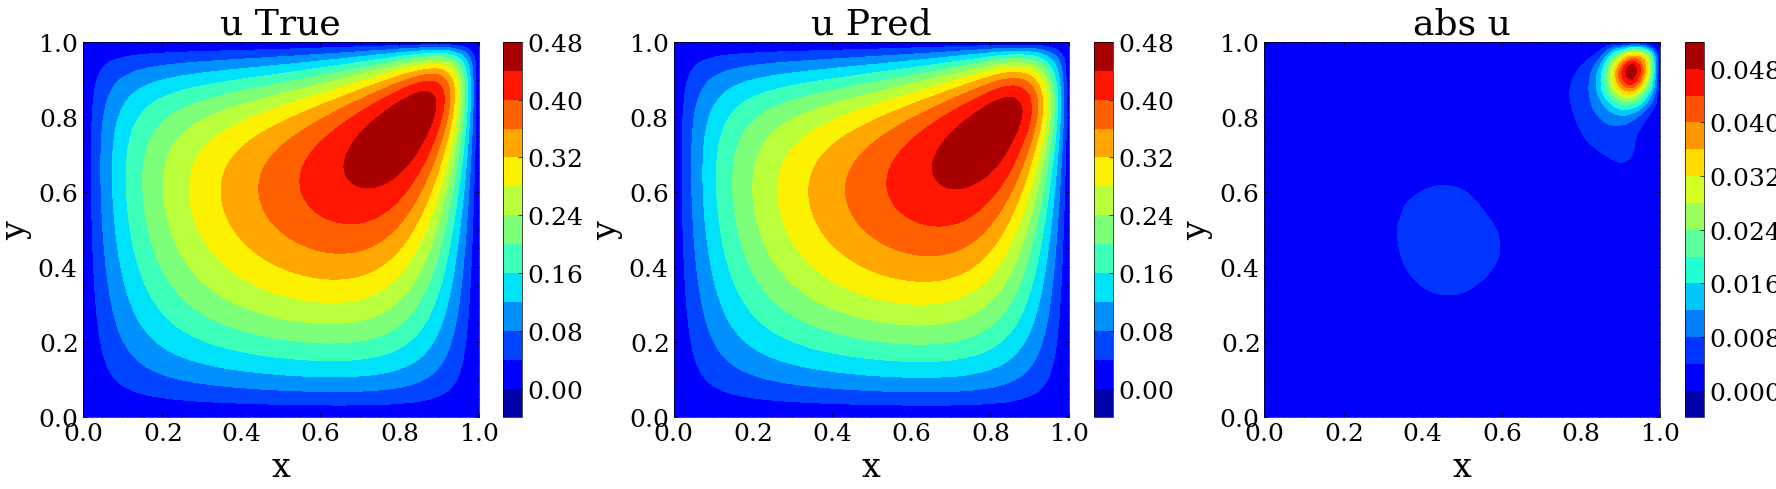

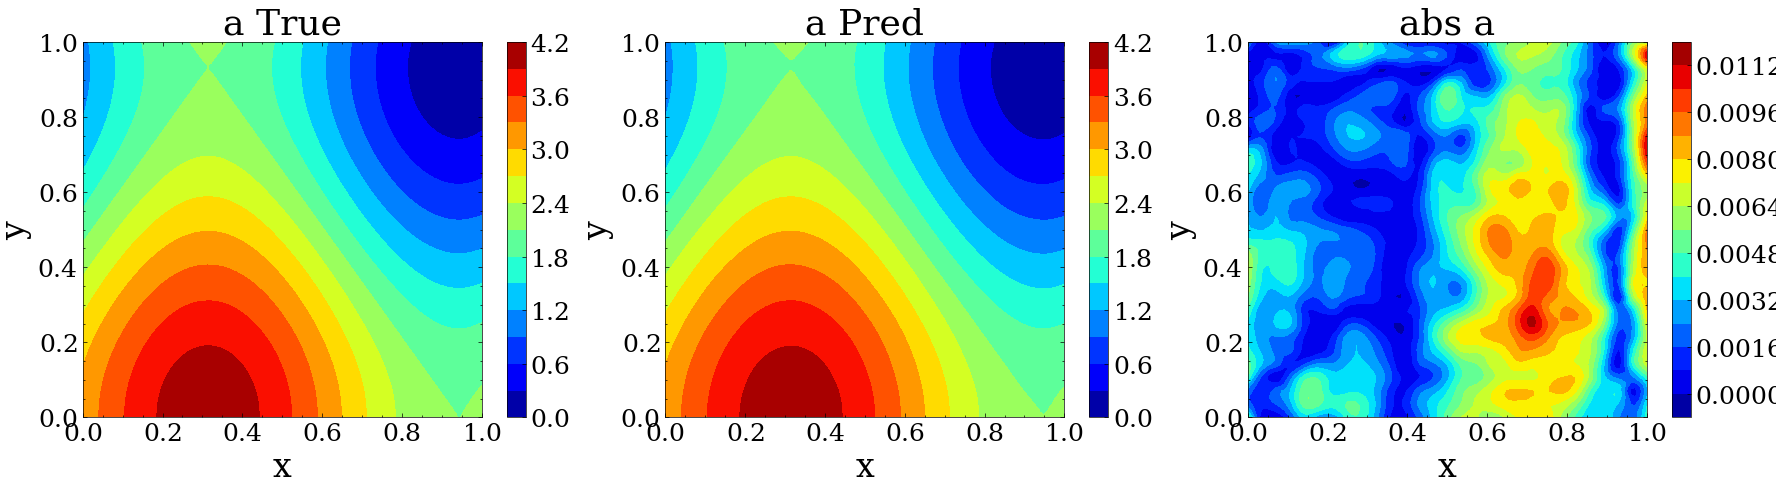

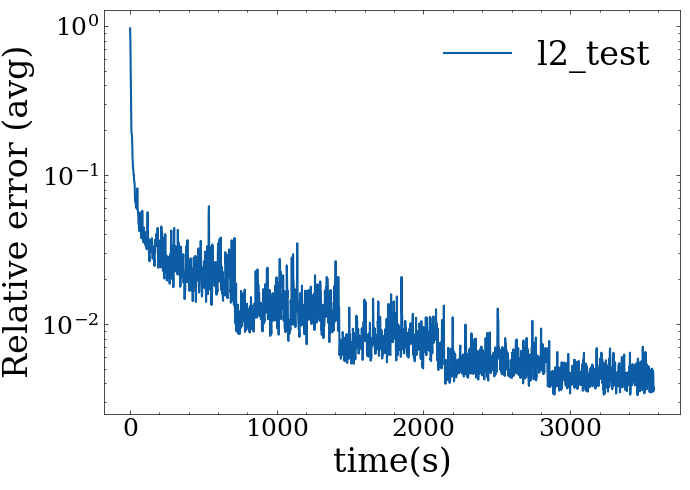

In [3]:
# #####################################
# # Load the trained model
# #####################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/DGNO_latent{beta_size}/', 
                                 name=f'model_dgno_besterror')

#########################################
with torch.no_grad():
    x_a = gridx_train.repeat(a_test.shape[0], 1, 1).to(device)
    x_u = x_test.to(device)
    #
    beta_pred = model_trained['enc'](a_test.to(device))
    u_pred = model_trained['u'](x_u, beta_pred)
    a_pred = model_trained['a'](x_a, beta_pred)
    u_pred = mollifier()(u_pred, x_u).detach().cpu()
    a_pred = a_pred.detach().cpu().unsqueeze(-1)
print('The test l2 error (u avg):', solver.getError(u_pred, u_test))
print('The test l2 error (a avg):', solver.getError(a_pred, a_test))

# # ########################################
from Utils.PlotFigure import Plot
inx = 0
Plot.show_2d_list(gridx_test, [u_test[inx], u_pred[inx], abs(u_pred[inx]-u_test[inx])],
                 ['u True', 'u Pred', 'abs u'], lb=0.)
Plot.show_2d_list(gridx_train, [a_test[inx], a_pred[inx], abs(a_pred[inx]-a_test[inx])],
                 ['a True', 'a Pred', 'abs a'], lb=0.)
#############################################
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/DGNO_latent{beta_size}/', name='loss_dgno')
# Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test'], loss_saved['loss_data'], loss_saved['loss_pde']], 
#                ['loss_train', 'loss_test', 'loss_data', 'loss_pde'])
# show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['error']], ['l2_test'])